<a href="https://colab.research.google.com/github/MoosaSaadat/handsonml/blob/master/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt

tf.executing_eagerly()

True

In [2]:
model = VGG19(
    include_top=False,
    weights="imagenet"
)

model.trainable = False
model.summary()

80142336/80134624 [==============================] - 2s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [3]:
# Utility functions
def load_and_process_image(img_path):
  img = load_img(img_path)
  img = img_to_array(img)
  img = preprocess_input(img)
  img = np.expand_dims(img, axis=0)
  return img

def deprocess(x):
  x[:,:,0] += 103.939
  x[:,:,1] += 116.779
  x[:,:,2] += 123.680
  x = x[:,:,::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x

def display_image(image):
  if len(image.shape) == 4:
    img = np.squeeze(image, axis=0)

  img = deprocess(img)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img)

In [6]:
content_layer = "block5_conv2"
style_layers = [
    "block1_conv1",
    "block3_conv1",
    "block5_conv1"
]

content_model = Model(
    inputs = model.input,
    outputs = model.get_layer(content_layer).output
)

style_models = [Model(
    inputs = model.input,
    outputs = model.get_layer(style_layer). output
) for style_layer in style_layers]

In [7]:
def content_cost(content, generated):
  a_C = content_model(content)
  a_G = content_model(generated)
  cost = tf.reduce_mean(tf.square(a_C - a_G))
  return cost

In [8]:
def gram_matrix(A):
  n_C = int(A.shape[-1])
  a = tf.reshape(A, shape=[-1, n_C])
  n = tf.shape(a)[0]
  G = tf.matmul(a, a, transpose_a=True)
  return G / tf.cast(n, tf.float32)

In [9]:
def style_cost(style, generated):
  total_cost = 0

  for style_model in style_models:
    a_S = style_model(style)
    a_G = style_model(generated)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    current_cost = tf.reduce_mean(tf.square(GS - GG))
    total_cost += current_cost * (1 / len(style_models))

  return total_cost

In [17]:
from datetime import datetime

start_time = datetime.now()
generated_images = []

def training_loop(content_path, style_path, iterations = 20,
                  alpha=10, beta=40):
  content = load_and_process_image(content_path)
  style = load_and_process_image(style_path)

  generated = tf.Variable(content, dtype=tf.float32)

  opt = tf.keras.optimizers.Adam(learning_rate=7)

  best_cost = float('inf')
  best_image = None

  for i in range(iterations):
    with tf.GradientTape() as tape:
      J_content = content_cost(content, generated)
      J_style = style_cost(style, generated)
      J_total = alpha * J_content + beta * J_style
    
    grads = tape.gradient(J_total, generated)
    opt.apply_gradients([(grads, generated)])

    if J_total < best_cost:
      best_cost = J_total
      best_image = generated.numpy()
    
    print(f"Cost at {i}: {J_total} {datetime.now() - start_time}")
    generated_images.append(generated.numpy())

  return best_image

In [18]:
best_iamge = training_loop('content.jpg', 'style.jpg')

Cost at 0: 27467970560.0 0:00:11.827180
Cost at 1: 17011439616.0 0:00:22.717210
Cost at 2: 10673193984.0 0:00:33.611927
Cost at 3: 8256854016.0 0:00:44.515902
Cost at 4: 6634896896.0 0:00:55.414639
Cost at 5: 5579649536.0 0:01:06.295321
Cost at 6: 4999249920.0 0:01:17.179401
Cost at 7: 4529843200.0 0:01:28.072323
Cost at 8: 4068545536.0 0:01:38.978480
Cost at 9: 3649414400.0 0:01:49.895995
Cost at 10: 3282256640.0 0:02:00.801918
Cost at 11: 2943834368.0 0:02:11.710001
Cost at 12: 2639301888.0 0:02:22.623221
Cost at 13: 2391624960.0 0:02:33.643720
Cost at 14: 2200929280.0 0:02:44.573951
Cost at 15: 2044911360.0 0:02:55.463687
Cost at 16: 1910248832.0 0:03:06.340581
Cost at 17: 1787406208.0 0:03:17.223331
Cost at 18: 1673171328.0 0:03:28.111932
Cost at 19: 1569462528.0 0:03:39.021845


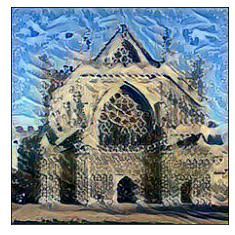

In [20]:
display_image(best_iamge)

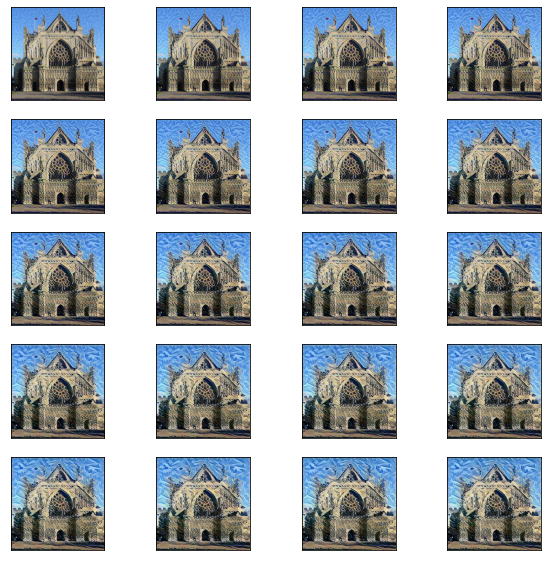

In [21]:
plt.figure(figsize = (10,10))

for i in range(20):
  plt.subplot(5, 4, i+1)
  display_image(generated_images[i])

plt.show()